
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [85]:
import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [54]:
DATASET = 'b2w'

#Dropout: 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.05

#Learning rate: 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 5e-4

FOLDS = 10

In [21]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [55]:
df = pd.read_csv(f'../datasets/{DATASET}_preprocessed.csv')

In [56]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [60]:
print(f'dataset preprocessado e balanceado: {DATASET} -> {df.shape[0]} instancias')

dataset preprocessado e balanceado: b2w -> 71516 instancias


In [61]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

#### Tentativa de treinamento com 10% do dataset

In [68]:
bach_01_text_train, bach_01_text_test, bach_01_labels_train, bach_01_labels_test = train_test_split(df['review_text'], df['rating'], train_size=0.1, random_state=42)

In [69]:
print(f'{bach_01_text_train.shape[0]} para treinamento')

7151 para treinamento


In [70]:
bach_01_labels_train.value_counts()

rating
0    3664
1    3487
Name: count, dtype: int64

In [71]:
reviews = bach_01_text_train
labels = bach_01_labels_train

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [73]:
embeddings = []
for review in reviews:
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

In [102]:
embeddings_array = np.vstack(embeddings)

In [103]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

7151 embeddings de 768 dimensões


#### Feature based 1

In [104]:
additional_features = np.array([[len(str(review).split())] for review in reviews])

In [105]:
print(embeddings_array.shape)
print(additional_features.shape)

(7151, 768)
(7151, 1)


#### Combinando embeddings_array e additional_features

In [106]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [107]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [108]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [109]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [110]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 24)                18480     
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [112]:
CHECKPOINT=ModelCheckpoint(filepath='../weights/tlm_peq_fb1_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

#### Cross-validation

In [113]:
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

#### Treinamento do modelo

In [114]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
        
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])

print("Media Accuracy Validacao:", np.mean(fold_accuracies))
print("Media f1 score Validacao", np.mean(fold_f1_scores))

fold = 1
Epoch 1/10
188/202 [==========================>...] - ETA: 0s - loss: 0.6047 - accuracy: 0.6970
Epoch 1: val_loss improved from inf to 0.49253, saving model to ../weights/tlm_peq_fb1_weights.hdf5
202/202 [==============================] - 1s 2ms/step - loss: 0.5979 - accuracy: 0.7021 - val_loss: 0.4925 - val_accuracy: 0.7919
Epoch 2/10
197/202 [============================>.] - ETA: 0s - loss: 0.4338 - accuracy: 0.8295
Epoch 2: val_loss improved from 0.49253 to 0.38258, saving model to ../weights/tlm_peq_fb1_weights.hdf5
202/202 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.8305 - val_loss: 0.3826 - val_accuracy: 0.8478
Epoch 3/10
171/202 [========================>.....] - ETA: 0s - loss: 0.3513 - accuracy: 0.8651
Epoch 3: val_loss improved from 0.38258 to 0.31012, saving model to ../weights/tlm_peq_fb1_weights.hdf5
202/202 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8690 - val_loss: 0.3101 - val_accuracy: 0.8869
Ep

In [115]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

45/45 [==============================] - 0s 1ms/step - loss: 0.1413 - accuracy: 0.9518


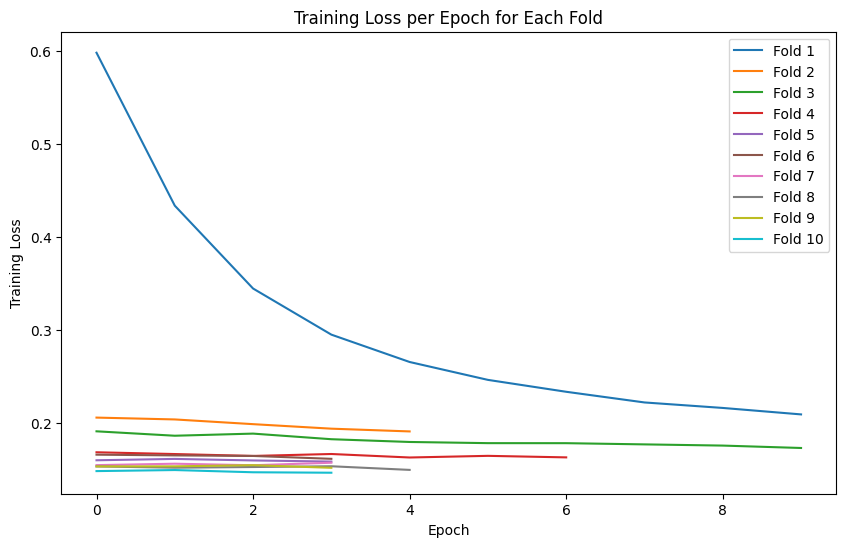

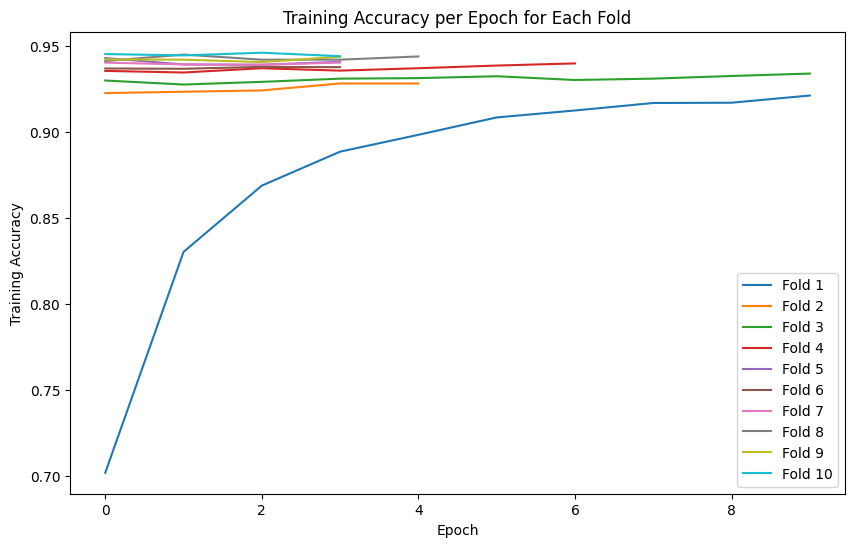

In [116]:
plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()